In [1]:
!git clone --single-branch --branch mahdis-yaghoubi https://github.com/Ai-ithub/iFDC---FDDDC.git


Cloning into 'iFDC---FDDDC'...
remote: Enumerating objects: 144, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 144 (delta 58), reused 126 (delta 50), pack-reused 0 (from 0)
Receiving objects: 100% (144/144), 194.25 KiB | 2.18 MiB/s, done.
Resolving deltas: 100% (58/58), done.


In [2]:
!pip install flask==2.3.3 flask-cors==4.0.0 pytest==7.4.0 python-dotenv==1.0.0 requests==2.31.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.1/96.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successfully uninstalled requests-2.32.3
  Attempting uninstall: pytest
    Found existing installation: pytest 8.3.5
    Uninstalling pytest-8.3.5:
      Successfully uninstalled pytest-8.3.5
  Attempting uninstall: flask
    Found existing installation: Flask 3.1.0
    Uninstalling Flask-3.1.0:
      Successfully uninstalled Flask-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.3, but you have requests 2.31.0 which is incompatible.


In [3]:
!pip install xgboost shap scikit-learn pandas matplotlib


In [2]:
import os
print(os.path.exists("data.py"))

True


In [9]:
import os
print(os.path.exists("synthetic_drilling_data.csv"))

True


ستون‌های داده: Index(['pressure', 'flow_rate', 'viscosity', 'depth', 'temperature',
       'shear_rate', 'salinity', 'ph', 'mud_weight', 'rock_type',
       'fluid_loss_risk'],
      dtype='object')
تعداد نمونه‌ها: 10000000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1972185
           1       0.99      0.99      0.99     27815

    accuracy                           1.00   2000000
   macro avg       0.99      1.00      1.00   2000000
weighted avg       1.00      1.00      1.00   2000000



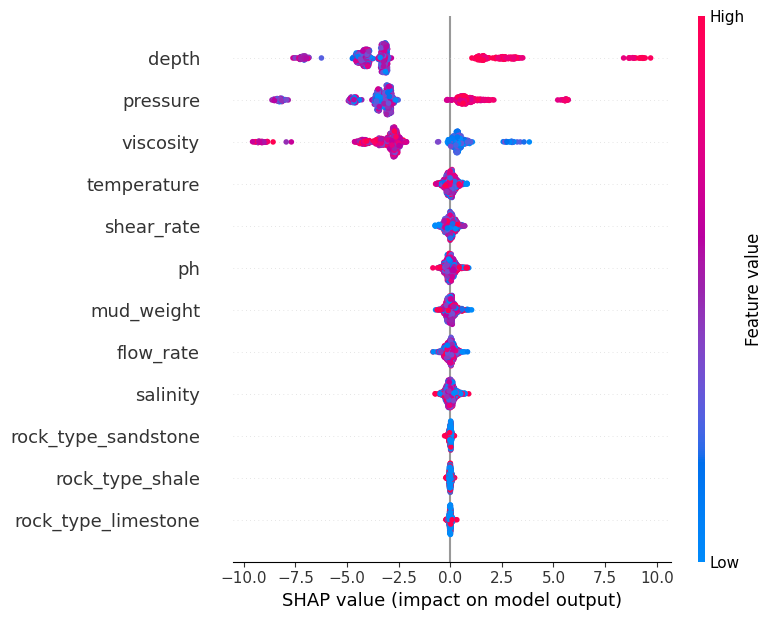

In [14]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import shap
import os

# بررسی وجود فایل CSV
csv_file = "synthetic_drilling_data.csv"
if not os.path.exists(csv_file):
    print("فایل synthetic_drilling_data.csv یافت نشد. اجرای data.py...")
    try:
        %run data.py
    except Exception as e:
        print("خطا در اجرای data.py:", e)
        exit()

# خواندن فایل CSV
try:
    data = pd.read_csv(csv_file)
    print("ستون‌های داده:", data.columns)
    print("تعداد نمونه‌ها:", len(data))
except Exception as e:
    print("خطا در خواندن فایل CSV:", e)
    exit()

# کدگذاری rock_type
data = pd.get_dummies(data, columns=['rock_type'], prefix='rock_type')

# انتخاب ویژگی‌ها (تمام ویژگی‌ها به جز fluid_loss_risk)
X = data.drop('fluid_loss_risk', axis=1)
y = data['fluid_loss_risk']

# تقسیم داده‌ها
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# آموزش مدل XGBoost
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    subsample=0.8,
    random_state=42,
    tree_method='hist',
    device='cuda' if os.environ.get('COLAB_GPU') else 'cpu'
)
model.fit(X_train, y_train)

# ارزیابی مدل
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# تحلیل SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test.sample(1000, random_state=42))
shap.summary_plot(shap_values, X_test.sample(1000, random_state=42))

# ذخیره مدل
model.save_model("xgboost_model.json")